## Importation & cleaning

In [1]:
# Formule Excel à utiliser pour la colonne 'Motion'
# =SI(ESTNUM(CHERCHE("Free Kick"; V417)); "Free Kick"; SI(ESTNUM(CHERCHE("Fouled"; S417)); "Penalty Kick"; SI(ESTNUM(CHERCHE("Dead"; S417)); "Set Piece"; SI(ESTNUM(CHERCHE("Dead"; U417)); "Set Piece"; "In Game"))))

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Bibliothèques utilisées dans le fichier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [4]:
!pip install unidecode
from unidecode import unidecode
from difflib import SequenceMatcher

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 9.0 MB/s eta 0:00:00


### Teams Overall

In [5]:
# Importation de la page générale de stats sur les équipes
with open("/content/drive/My Drive/Premier League Project/overall.txt", "r", encoding="utf-8") as file:
    overall_page = file.read()

In [7]:
### Teams Overall
# Utiliser BeautifulSoup pour extraire les données
soup_teamsoverall = BeautifulSoup(overall_page, "html.parser")
table_teamsoverall = soup_teamsoverall.find("table", class_="stats_table sortable min_width force_mobilize now_sortable", id="results2023-202491_overall")

# Extraire les en-têtes de colonnes
headers_teamsoverall = [th.get_text(strip=True) for th in table_teamsoverall.find("thead").find_all("th")]
# Exclure les 5 dernières colonnes
headers_teamsoverall = headers_teamsoverall[:-4]

# Initialiser une liste pour stocker les données des équipes
data_rows = []

# Parcourir les lignes de la balise tbody
for row in table_teamsoverall.find("tbody").find_all("tr"):
    # Extraire les données de chaque colonne dans une liste
    row_data = [td.get_text(strip=True) for td in row.find_all(["th", "td"])][:-4]
    row_data[headers_teamsoverall.index("MP")] = int(row_data[headers_teamsoverall.index("MP")])
    row_data[headers_teamsoverall.index("W")] = int(row_data[headers_teamsoverall.index("W")])
    row_data[headers_teamsoverall.index("D")] = int(row_data[headers_teamsoverall.index("D")])
    row_data[headers_teamsoverall.index("L")] = int(row_data[headers_teamsoverall.index("L")])
    row_data[headers_teamsoverall.index("GF")] = int(row_data[headers_teamsoverall.index("GF")])
    row_data[headers_teamsoverall.index("GA")] = int(row_data[headers_teamsoverall.index("GA")])
    row_data[headers_teamsoverall.index("GD")] = int(row_data[headers_teamsoverall.index("GD")])
    row_data[headers_teamsoverall.index("Pts")] = int(row_data[headers_teamsoverall.index("Pts")])
    row_data[headers_teamsoverall.index("Pts/MP")] = float(row_data[headers_teamsoverall.index("Pts/MP")])
    row_data[headers_teamsoverall.index("xG")] = float(row_data[headers_teamsoverall.index("xG")])
    row_data[headers_teamsoverall.index("xGA")] = float(row_data[headers_teamsoverall.index("xGA")])
    row_data[headers_teamsoverall.index("xGD")] = float(row_data[headers_teamsoverall.index("xGD")])
    row_data[headers_teamsoverall.index("xGD/90")] = float(row_data[headers_teamsoverall.index("xGD/90")])

    # Ajouter les données à la liste principale
    data_rows.append(row_data)

In [8]:
# Créer un DataFrame à partir des données extraites
teamsoverall = pd.DataFrame(data_rows, columns=headers_teamsoverall)
# Renommer la colonne 'Squad' en 'Team'
teamsoverall = teamsoverall.rename(columns={'Squad': 'Team'})

### Teams Home/Away

In [9]:
### Teams Home Away
# Utiliser BeautifulSoup pour extraire les données
soup_teamshomeaway = BeautifulSoup(overall_page, "html.parser")
table_teamshomeaway = soup_teamshomeaway.find("table", class_="stats_table sortable min_width force_mobilize now_sortable", id="results2023-202491_home_away")

# Extraire les en-têtes de colonnes
headers_teamshomeaway = [th.get_text(strip=True) for th in table_teamshomeaway.find("thead").find_all("th")]
headers_teamshomeaway = headers_teamshomeaway[3:]

# Créer un dictionnaire pour suivre les occurrences
occurrences = {}

# Parcourir la liste et ajouter les suffixes
for i, header in enumerate(headers_teamshomeaway):
    if header not in ['Rk', 'Squad']:  # Ignorer 'Rk' et 'Squad'
        if header in occurrences:
            # Si l'élément est déjà rencontré, ajouter le suffixe ' Away'
            headers_teamshomeaway[i] += ' Away'
        else:
            # Si c'est la première occurrence, ajouter le suffixe ' Home'
            headers_teamshomeaway[i] += ' Home'
            occurrences[header] = True  # Marquer comme rencontré

# Initialiser une liste pour stocker les données des équipes
data_rows = []

# Parcourir les lignes de la balise tbody
for row in table_teamshomeaway.find("tbody").find_all("tr"):
    # Extraire les données de chaque colonne dans une liste
    row_data = [td.get_text(strip=True) for td in row.find_all(["th", "td"])]
    row_data[headers_teamshomeaway.index("MP Home")] = int(row_data[headers_teamshomeaway.index("MP Home")])
    row_data[headers_teamshomeaway.index("W Home")] = int(row_data[headers_teamshomeaway.index("W Home")])
    row_data[headers_teamshomeaway.index("D Home")] = int(row_data[headers_teamshomeaway.index("D Home")])
    row_data[headers_teamshomeaway.index("L Home")] = int(row_data[headers_teamshomeaway.index("L Home")])
    row_data[headers_teamshomeaway.index("GF Home")] = int(row_data[headers_teamshomeaway.index("GF Home")])
    row_data[headers_teamshomeaway.index("GA Home")] = float(row_data[headers_teamshomeaway.index("GA Home")])
    row_data[headers_teamshomeaway.index("GD Home")] = float(row_data[headers_teamshomeaway.index("GD Home")])
    row_data[headers_teamshomeaway.index("Pts Home")] = float(row_data[headers_teamshomeaway.index("Pts Home")])
    row_data[headers_teamshomeaway.index("Pts/MP Home")] = float(row_data[headers_teamshomeaway.index("Pts/MP Home")])
    row_data[headers_teamshomeaway.index("xG Home")] = float(row_data[headers_teamshomeaway.index("xG Home")])
    row_data[headers_teamshomeaway.index("xGA Home")] = float(row_data[headers_teamshomeaway.index("xGA Home")])
    row_data[headers_teamshomeaway.index("xGD Home")] = float(row_data[headers_teamshomeaway.index("xGD Home")])
    row_data[headers_teamshomeaway.index("xGD/90 Home")] = float(row_data[headers_teamshomeaway.index("xGD/90 Home")])
    row_data[headers_teamshomeaway.index("MP Away")] = int(row_data[headers_teamshomeaway.index("MP Away")])
    row_data[headers_teamshomeaway.index("W Away")] = int(row_data[headers_teamshomeaway.index("W Away")])
    row_data[headers_teamshomeaway.index("D Away")] = int(row_data[headers_teamshomeaway.index("D Away")])
    row_data[headers_teamshomeaway.index("L Away")] = int(row_data[headers_teamshomeaway.index("L Away")])
    row_data[headers_teamshomeaway.index("GF Away")] = int(row_data[headers_teamshomeaway.index("GF Away")])
    row_data[headers_teamshomeaway.index("GA Away")] = float(row_data[headers_teamshomeaway.index("GA Away")])
    row_data[headers_teamshomeaway.index("GD Away")] = float(row_data[headers_teamshomeaway.index("GD Away")])
    row_data[headers_teamshomeaway.index("Pts Away")] = float(row_data[headers_teamshomeaway.index("Pts Away")])
    row_data[headers_teamshomeaway.index("Pts/MP Away")] = float(row_data[headers_teamshomeaway.index("Pts/MP Away")])
    row_data[headers_teamshomeaway.index("xG Away")] = float(row_data[headers_teamshomeaway.index("xG Away")])
    row_data[headers_teamshomeaway.index("xGA Away")] = float(row_data[headers_teamshomeaway.index("xGA Away")])
    row_data[headers_teamshomeaway.index("xGD Away")] = float(row_data[headers_teamshomeaway.index("xGD Away")])
    row_data[headers_teamshomeaway.index("xGD/90 Away")] = float(row_data[headers_teamshomeaway.index("xGD/90 Away")])

    # Ajouter les données à la liste principale
    data_rows.append(row_data)

In [10]:
# Créer un DataFrame à partir des données extraites
teamshomeaway = pd.DataFrame(data_rows, columns=headers_teamshomeaway)
# Renommer la colonne 'Squad' en 'Team'
teamshomeaway = teamshomeaway.rename(columns={'Squad': 'Team'})

### Teams Miscellaneous

In [11]:
### Teams Miscellaneous
# Using BeautifulSoup to extract data
soup_teamsmisc = BeautifulSoup(overall_page, "html.parser")
table_teamsmisc = soup_teamsmisc.find("table", class_="stats_table sortable min_width now_sortable", id="stats_squads_misc_for")

# Extract column headers
headers_teamsmisc = [th.get_text(strip=True) for th in table_teamsmisc.find("thead").find_all("th")]
# Exclude the last 5 columns
headers_teamsmisc = headers_teamsmisc[3:]

# Initialise a list to store team data
data_rows = []

# Browse lines in the tbody tag
for row in table_teamsmisc.find("tbody").find_all("tr"):
    # Extract data from each column in a list
    row_data = [td.get_text(strip=True) for td in row.find_all(["th", "td"])]
    row_data[headers_teamsmisc.index("# Pl")] = int(row_data[headers_teamsmisc.index("# Pl")])
    row_data[headers_teamsmisc.index("90s")] = float(row_data[headers_teamsmisc.index("90s")])
    row_data[headers_teamsmisc.index("CrdY")] = int(row_data[headers_teamsmisc.index("CrdY")])
    row_data[headers_teamsmisc.index("CrdR")] = int(row_data[headers_teamsmisc.index("CrdR")])
    row_data[headers_teamsmisc.index("2CrdY")] = int(row_data[headers_teamsmisc.index("2CrdY")])
    row_data[headers_teamsmisc.index("Fls")] = int(row_data[headers_teamsmisc.index("Fls")])
    row_data[headers_teamsmisc.index("Fld")] = int(row_data[headers_teamsmisc.index("Fld")])
    row_data[headers_teamsmisc.index("Off")] = int(row_data[headers_teamsmisc.index("Off")])
    row_data[headers_teamsmisc.index("Crs")] = int(row_data[headers_teamsmisc.index("Crs")])
    row_data[headers_teamsmisc.index("Int")] = int(row_data[headers_teamsmisc.index("Int")])
    row_data[headers_teamsmisc.index("TklW")] = int(row_data[headers_teamsmisc.index("TklW")])
    row_data[headers_teamsmisc.index("PKwon")] = int(row_data[headers_teamsmisc.index("PKwon")])
    row_data[headers_teamsmisc.index("PKcon")] = int(row_data[headers_teamsmisc.index("PKcon")])
    row_data[headers_teamsmisc.index("OG")] = int(row_data[headers_teamsmisc.index("OG")])
    row_data[headers_teamsmisc.index("Recov")] = int(row_data[headers_teamsmisc.index("Recov")])
    row_data[headers_teamsmisc.index("Won")] = int(row_data[headers_teamsmisc.index("Won")])
    row_data[headers_teamsmisc.index("Lost")] = int(row_data[headers_teamsmisc.index("Lost")])
    row_data[headers_teamsmisc.index("Won%")] = float(row_data[headers_teamsmisc.index("Won%")])

    # Add data to the main list
    data_rows.append(row_data)

In [12]:
# Create a DataFrame from extracted data
teamsmisc = pd.DataFrame(data_rows, columns=headers_teamsmisc)
# Rename the 'Squad' column to 'Team'
teamsmisc = teamsmisc.rename(columns={'Squad': 'Team'})

### All players

In [13]:
# Ajouts de la liste de tous les joueurs
with open("/content/drive/My Drive/Premier League Project/allplayers.txt", "r", encoding="utf-8") as file:
    allplayers_page = file.read()

In [14]:
### All players
# Using BeautifulSoup to extract data
soup_allplayers = BeautifulSoup(allplayers_page, "html.parser")
table_allplayers = soup_allplayers.find("table", class_="min_width sortable stats_table shade_zero now_sortable sticky_table eq2 re2 le2")

# Extract column headers
headers_allplayers = [th.get_text(strip=True) for th in table_allplayers.find("thead").find_all("th")]
# Exclude the first 8 columns
headers_allplayers = headers_allplayers[7:]

# Initialise a list to store player data
data_rows = []

# Browse lines in the tbody tag
for row in table_allplayers.find("tbody").find_all("tr"):
    # Extract data from each column in a list
    row_data = [td.get_text(strip=True) for td in row.find_all(["th", "td"])]
    # Convert the minutes format if necessary
    if "Min" in headers_allplayers:
        row_data[headers_allplayers.index("Min")] = row_data[headers_allplayers.index("Min")].replace(",", "")
    # Add data to the main list
    data_rows.append(row_data)

# Ensure that all rows have the same number of columns
max_cols = max(len(row) for row in data_rows)
data_rows = [row + [""] * (max_cols - len(row)) for row in data_rows]

In [15]:
# Create a DataFrame from extracted data
allplayers = pd.DataFrame(data_rows, columns=headers_allplayers)
# Delete the first and last columns of the DataFrame
allplayers = allplayers.drop(columns=[allplayers.columns[0], allplayers.columns[-1]])
# Rename the 'Squad' column to 'Team' and convert 'Min' format in numeric
allplayers = allplayers.rename(columns={'Squad': 'Team'})
allplayers['Min'] = pd.to_numeric(allplayers['Min'], errors='coerce')

### Fixtures

In [16]:
# Importing the list of all team fixtures
with open("/content/drive/My Drive/Premier League Project/fixtures.txt", "r", encoding="utf-8") as file:
    fixtures_page = file.read()

In [17]:
### Fixtures
# Using BeautifulSoup to extract data
soup_fixtures = BeautifulSoup(fixtures_page, "html.parser")
table_fixtures = soup_fixtures.find("table", class_="stats_table sortable min_width now_sortable sticky_table eq5 eq9 re9 le5")

# Extract column headers
headers_fixtures = [th.get_text(strip=True) for th in table_fixtures.find("thead").find_all("th")]
# Excluding the 2nd, 4th and 5th elements from the end
headers_fixtures = headers_fixtures[:-2]

# Browse the list and add suffixes to 'xG' items
for i in range(len(headers_fixtures)):
    if headers_fixtures[i] == 'xG':
        # Add the suffix 'Home' to the first 'xG'
        headers_fixtures[i] += ' Home'
        break  # Stop the loop after finding the first 'xG'

for i in range(len(headers_fixtures)):
    if headers_fixtures[i] == 'xG':
        # Add the suffix 'Away' to the second 'xG'
        headers_fixtures[i] += ' Away'
        break  # Stop the loop after finding the second 'xG'

# Initialise a list to store fixtures data
data_rows = []

for row in table_fixtures.find("tbody").find_all("tr"):
    # Extract data from each column in a list
    row_data = [td.get_text(strip=True) for td in row.find_all(["th", "td"])][:-2]
    # Ignore the list if it contains only empty strings
    if not all(value == '' for value in row_data):
        # Convert the Attendance format if necessary
        if "Attendance" in headers_fixtures:
            row_data[headers_fixtures.index("Attendance")] = row_data[headers_fixtures.index("Attendance")].replace(",", "")
        # Add data to the main list
        data_rows.append(row_data)

In [18]:
# Create a DataFrame from extracted data
fixtures = pd.DataFrame(data_rows, columns=headers_fixtures)
fixtures['Wk'] = pd.to_numeric(fixtures['Wk'], errors='coerce').fillna(40).astype(int)
fixtures['xG Home'] = pd.to_numeric(fixtures['xG Home'], errors='coerce')
fixtures['xG Away'] = pd.to_numeric(fixtures['xG Away'], errors='coerce')
fixtures['Attendance'] = pd.to_numeric(fixtures['Attendance'].str.replace(',', ''), errors='coerce').fillna(0).astype(int)

### Reformatage des DataFrame

In [19]:
# Renommage des équipes avec des apostrophes
teamshomeaway['Team'] = teamshomeaway['Team'].replace("Nott'ham Forest", "Nottingham Forest")
teamsoverall['Team'] = teamsoverall['Team'].replace("Nott'ham Forest", "Nottingham Forest")
fixtures['Home'] = fixtures['Home'].replace("Nott'ham Forest", "Nottingham Forest")
fixtures['Away'] = fixtures['Away'].replace("Nott'ham Forest", "Nottingham Forest")
allplayers['Team'] = allplayers['Team'].replace("Nott'ham Forest", "Nottingham Forest")

In [20]:
# Changement du format du tiret
fixtures['Score'] = fixtures['Score'].str.replace('–', '-')

# Séparation des scores des équipes
fixtures[['HomeScore', 'AwayScore']] = fixtures['Score'].str.split('-', expand=True).apply(pd.to_numeric, errors='coerce')
fixtures['HomeScore'] = fixtures['HomeScore'].fillna(0).astype(int)
fixtures['AwayScore'] = fixtures['AwayScore'].fillna(0).astype(int)

# Attribution des points selon le score : si score supérieur, alors 3 points et l'autre 0 point, si égalité, alors 1 point chacun
fixtures['HomePts'] = np.where(fixtures['HomeScore'] > fixtures['AwayScore'], 3, np.where(fixtures['HomeScore'] < fixtures['AwayScore'], 0, 1))
fixtures['AwayPts'] = np.where(fixtures['HomeScore'] < fixtures['AwayScore'], 3, np.where(fixtures['HomeScore'] > fixtures['AwayScore'], 0, 1))

In [21]:
# Création des index d'efficacité offensive et défensive
teamsoverall['offensive efficiency'] = teamsoverall['GF'] - teamsoverall['xG'] #si positif, alors efficace
teamsoverall['defensive efficiency'] = teamsoverall['GA'] - teamsoverall['xGA'] #si négatif, alors efficace
teamshomeaway['offensive efficiency Home'] = teamshomeaway['GF Home'] - teamshomeaway['xG Home'] #si positif, alors efficace
teamshomeaway['offensive efficiency Away'] = teamshomeaway['GF Away'] - teamshomeaway['xG Away'] #si positif, alors efficace
teamshomeaway['defensive efficiency Home'] = teamshomeaway['GA Home'] - teamshomeaway['xGA Home'] #si négatif, alors efficace
teamshomeaway['defensive efficiency Away'] = teamshomeaway['GA Away'] - teamshomeaway['xGA Away'] #si négatif, alors efficace

In [22]:
# Dataframe dans lequel on aura toutes les informations pour chaque équipe
teams_final = pd.merge(teamshomeaway, teamsoverall[['Team', 'offensive efficiency', 'defensive efficiency']], on='Team', how='left')

In [23]:
teams_final

,Rk,Team,MP Home,W Home,D Home,L Home,GF Home,GA Home,GD Home,Pts Home,...,xG Away,xGA Away,xGD Away,xGD/90 Away,offensive efficiency Home,offensive efficiency Away,defensive efficiency Home,defensive efficiency Away,offensive efficiency,defensive efficiency
0,1,Manchester City,19,14,5,0,51,16.0,35.0,47.0,...,39.8,21.6,18.2,0.96,10.4,5.2,2.0,-3.6,15.5,-1.6
1,2,Arsenal,19,15,2,2,48,16.0,32.0,47.0,...,32.6,14.5,18.2,0.96,4.7,10.4,2.6,-1.5,15.0,1.2
2,3,Liverpool,19,15,3,1,49,17.0,32.0,48.0,...,33.0,28.2,4.9,0.26,-6.2,4.0,-0.7,-4.2,-2.2,-4.8
3,4,Aston Villa,19,12,4,3,48,28.0,20.0,40.0,...,24.3,33.6,-9.3,-0.49,9.0,3.7,1.7,-0.6,12.6,1.1
4,5,Tottenham,19,13,0,6,38,27.0,11.0,39.0,...,28.9,34.1,-5.2,-0.27,-1.2,7.1,-2.3,-0.1,5.8,-2.4
5,6,Chelsea,19,11,4,4,44,26.0,18.0,37.0,...,30.3,33.1,-2.9,-0.15,-0.1,2.7,1.1,3.9,2.6,5.0
6,7,Newcastle Utd,19,12,4,3,49,22.0,27.0,40.0,...,29.8,36.3,-6.6,-0.34,2.6,6.2,-3.0,3.7,8.8,0.6
7,8,Manchester Utd,19,10,3,6,31,28.0,3.0,33.0,...,24.1,37.4,-13.2,-0.70,-1.3,1.9,-3.7,-7.4,0.6,-11.1
8,9,West Ham,19,7,8,4,31,28.0,3.0,29.0,...,26.1,41.3,-15.2,-0.80,4.7,2.9,-1.7,4.7,7.7,2.9
9,10,Crystal Palace,19,8,4,7,37,26.0,11.0,28.0,...,21.2,31.1,-9.9,-0.52,9.7,-1.2,5.1,0.9,8.4,6.0


## Joueurs blessés

site source des joueurs blessés : https://www.premierinjuries.com/injury-table.php. A cause des restrictions du site liées au scrapping, il faut copier le HTML lorsqu'on souhaite actualiser la liste des joueurs blessés, le coller dans un fichier texte que l'on utilisera à la place.  

---


**à mettre à jour avant chaque journée de championnat !**

### Récupération du nom des joueurs

In [24]:
#allplayers['Min'] = allplayers['Min'].str.replace(',', '').astype(int)
allplayers['Player'] = allplayers['Player'].replace("João Palhinha", "João Palhinha Goncalves")
allplayers['Player'] = allplayers['Player'].replace("Igor", "Igor Julio de Paulo")
allplayers['Player'] = allplayers['Player'].replace("Felipe", "Felipe de Almeida Monteiro")
allplayers['Player'] = allplayers['Player'].replace("Rodri", "Rodrigo Hernandez")
allplayers['Player'] = allplayers['Player'].replace("José Sá", "José Pedro Malheiro de Sá")
allplayers['Player'] = allplayers['Player'].replace("Willian", "Willian Borges Da Silva")
allplayers['Player'] = allplayers['Player'].replace("Murillo", "Murillo Santiago Costa")
allplayers['Player'] = allplayers['Player'].replace("Joelinton", "Joelinton Apolinário de Lira")
allplayers['Player'] = allplayers['Player'].replace("Jorginho", "Jorge Luiz Frello Filho")
allplayers['Player'] = allplayers['Player'].replace("João Pedro", "JJoao Pedro Junqueira de Jesus")

In [25]:
# Ouvrir le fichier texte et lire le contenu
with open('/content/drive/My Drive/Premier League Project/injured_players.txt', 'r') as f:
    injured_players_page = f.read()

In [26]:
# Analyser le contenu du fichier avec BeautifulSoup
soup_injured_players = BeautifulSoup(injured_players_page, 'html.parser')

# Trouver la table des blessures
table_injured_players = soup_injured_players.find('table', {'class': 'injury-table injury-table-full'})
# Trouver la dernière mise à jour de la liste des blessés
last_update_date = soup_injured_players.find('div', {'class': 'pi-table-timestamp'})

In [27]:
print(last_update_date.text)

Last update: 10 May 24 13:27 GMT


In [28]:
injured_players = pd.DataFrame(columns=['Team', 'Player', 'Reason', 'Return Date', 'Status'])

In [29]:
# Parcourir chaque ligne de la table
for row in table_injured_players.find_all('tr'):
    # Vérifier si la ligne a un attribut 'data-team-id'
    if 'data-team-id' in row.attrs:
        team_id = row['data-team-id']
        team_name = row.find('div', {'class': 'injury-team'}).text
    elif any('player-row' in cls for cls in row['class']):
        # Si la ligne a une classe qui contient 'player-row', alors c'est une ligne de joueur
        cells = row.find_all('td')
        if len(cells) > 1:
            # Les cellules contiennent différentes informations
            player_name = cells[0].text.replace('Player', '').strip()
            return_date = cells[3].text.replace('Potential Return', '').strip()
            reason = cells[1].text.replace('Reason', '').strip()
            chances_of_return = cells[5].text.replace('Status', '').strip()
            # Ajouter les informations au dataframe
            injured_players.loc[len(injured_players)] = {'Team': team_name, 'Player': player_name, 'Reason': reason, 'Return Date': return_date, 'Status': chances_of_return}

In [30]:
# Renommage des équipes de injured_players
injured_players['Team'] = injured_players['Team'].replace("AFC Bournemouth", "Bournemouth")
injured_players['Team'] = injured_players['Team'].replace("Brighton & Hove Albion", "Brighton")
injured_players['Team'] = injured_players['Team'].replace("Newcastle United", "Newcastle Utd")
injured_players['Team'] = injured_players['Team'].replace("AFC Bournemouth", "Bournemouth")
injured_players['Team'] = injured_players['Team'].replace("Sheffield United", "Sheffield Utd")
injured_players['Team'] = injured_players['Team'].replace("Tottenham Hotspur", "Tottenham")
injured_players['Team'] = injured_players['Team'].replace("West Ham United", "West Ham")
injured_players['Team'] = injured_players['Team'].replace("Wolverhampton Wanderers", "Wolves")
injured_players['Team'] = injured_players['Team'].replace("Manchester United", "Manchester Utd")

### Matching avec la base de joueurs Fbref

In [31]:
injured_players['PlayerCompared'] = injured_players['Player'].apply(lambda x: unidecode(x.replace(' ', '').lower()))
allplayers['PlayerCompared'] = allplayers['Player'].apply(lambda x: unidecode(x.replace(' ', '').lower()))

In [32]:
# Fonction pour calculer la similarité entre deux chaînes de caractères
def similarity(a, b):
    return SequenceMatcher(None, a, b).ratio()

# Fonction pour trouver le meilleur match pour un joueur blessé
def find_best_match(row):
    best_match = None
    best_score = 0.6  # seuil de similarité

    for i, player_row in allplayers.iterrows():
        # Vérifier si l'équipe correspond
        if row['Team'] != player_row['Team']:
            continue

        # Calculer la similarité
        score = similarity(row['PlayerCompared'], player_row['PlayerCompared'])

        # Mettre à jour le meilleur score et le meilleur match
        if score > best_score:
            best_score = score
            best_match = player_row

            # Imprimer le meilleur match et le score pour le débogage
            #print(f"Meilleur match pour {row['PlayerCompared']} in {row['Team']}: {best_match['PlayerCompared']} avec un score de {best_score}")

    if best_match is not None:
        return best_match['Min']
    else:
        # Imprimer les joueurs blessés qui ne sont pas trouvés dans allplayers, donc soit ils n'ont pas joué de l'année, soit leur nom dans allplayers est trop simplifié par rapport à leur nom complet
        print(f"Aucun match trouvé pour {row['PlayerCompared']} in {row['Team']}")
        return None


# Appliquer la fonction à chaque ligne du DataFrame 'injured_players'
injured_players['Min'] = injured_players.apply(find_best_match, axis=1)

Aucun match trouvé pour ryanfredericks in Bournemouth
Aucun match trouvé pour emilianobuendia in Aston Villa
Aucun match trouvé pour wesleyfofana in Chelsea
Aucun match trouvé pour robholding in Crystal Palace
Aucun match trouvé pour bamidelealli in Everton
Aucun match trouvé pour danpotts in Luton Town
Aucun match trouvé pour tyrellmalacia in Manchester Utd
Aucun match trouvé pour fraserforster in Tottenham
Aucun match trouvé pour ryansessegnon in Tottenham
Aucun match trouvé pour lucastolentinocoelhodelima in West Ham


In [33]:
# Calculer le nombre de fois qu'un type de blessure apparaît dans la colonne 'Reason'
injuries_count = injured_players['Reason'].value_counts()

In [34]:
injuries_count

Reason
Thigh Injury               30
Knee Injury                19
Other                      17
Calf/Shin/Heel Injury      14
Ankle/Foot Injury          14
Groin/Hip/Pelvic Injury     7
Illness                     4
Suspended                   3
Lower Back Injury           3
Head/Face Injury            1
Arm/Elbow Injury            1
Chest/Abdominal Injury      1
Wrist/Hand Injury           1
Name: count, dtype: int64

### Vérification des absents

In [35]:
injured_players[(injured_players['Team'] == 'Brighton')]

,Team,Player,Reason,Return Date,Status,PlayerCompared,Min
24,Brighton,Solomon March,Knee Injury,17/06/2024,Ruled Out,solomonmarch,554.0
25,Brighton,Evan Ferguson,Ankle/Foot Injury,03/06/2024,Ruled Out,evanferguson,1367.0
26,Brighton,Jack Hinshelwood,Ankle/Foot Injury,03/06/2024,Ruled Out,jackhinshelwood,869.0
27,Brighton,Pervis Estupinan,Calf/Shin/Heel Injury,03/06/2024,Ruled Out,pervisestupinan,1243.0
28,Brighton,Kaoru Mitoma,Lower Back Injury,03/06/2024,Ruled Out,kaorumitoma,1486.0
29,Brighton,James Milner,Thigh Injury,19/05/2024,Ruled Out,jamesmilner,773.0
30,Brighton,Tariq Lamptey,Other,11/05/2024,75%,tariqlamptey,914.0
31,Brighton,Adam Lallana,Other,11/05/2024,100%,adamlallana,850.0
32,Brighton,Joao Pedro Junqueira de Jesus,Ankle/Foot Injury,11/05/2024,50%,joaopedrojunqueiradejesus,2045.0
33,Brighton,Jan Paul van Hecke,Thigh Injury,No Return Date,Ruled Out,janpaulvanhecke,2369.0


In [36]:
allplayers[(allplayers['Player'] == 'João Pedro')]

,Player,Nation,Pos,Team,Age,Born,MP,Starts,Min,90s,...,Ast,G+A,G-PK,G+A-PK,xG,xAG,xG+xAG,npxG,npxG+xAG,PlayerCompared


In [37]:
injured_players[(injured_players['PlayerCompared'] == 'rodrigohernandezcascante')]

,Team,Player,Reason,Return Date,Status,PlayerCompared,Min


In [38]:
similarity("rodrigohernandezcascante", "rodrigohernandez")

0.8

### Index de l'impact des blessures dans chaque équipe

In [39]:
# Remplacer les valeurs NaN par 0 dans la colonne 'Min'
injured_players['Min'].fillna(0, inplace=True)

In [40]:
# Calculer la somme des minutes pour chaque équipe dans 'injured_players'
minutes_per_team = injured_players.groupby('Team')['Min'].sum()

In [41]:
minutes_per_team.sort_values(ascending=False)

Team
Manchester Utd       14545.0
Brighton             12470.0
Newcastle Utd         9884.0
Luton Town            9162.0
Sheffield Utd         7266.0
Crystal Palace        7238.0
Bournemouth           7084.0
Wolves                6867.0
Aston Villa           6665.0
Brentford             6446.0
Chelsea               5378.0
Burnley               5242.0
Tottenham             4489.0
Arsenal               4139.0
West Ham              3666.0
Everton               3474.0
Fulham                2447.0
Liverpool             1932.0
Nottingham Forest     1637.0
Name: Min, dtype: float64

In [42]:
# Créer l'index 'Important Player Injured Index' en divisant la somme des minutes jouées
ip2i_index = minutes_per_team / 110

In [43]:
# Attribuer l'index 'IP2I' à chaque équipe dans 'teams_final'
teams_final = teams_final.set_index('Team')
teams_final['IP2I'] = ip2i_index
teams_final.reset_index(inplace=True)

In [44]:
teams_final

,Team,Rk,MP Home,W Home,D Home,L Home,GF Home,GA Home,GD Home,Pts Home,...,xGA Away,xGD Away,xGD/90 Away,offensive efficiency Home,offensive efficiency Away,defensive efficiency Home,defensive efficiency Away,offensive efficiency,defensive efficiency,IP2I
0,Manchester City,1,19,14,5,0,51,16.0,35.0,47.0,...,21.6,18.2,0.96,10.4,5.2,2.0,-3.6,15.5,-1.6,NaN
1,Arsenal,2,19,15,2,2,48,16.0,32.0,47.0,...,14.5,18.2,0.96,4.7,10.4,2.6,-1.5,15.0,1.2,37.627273
2,Liverpool,3,19,15,3,1,49,17.0,32.0,48.0,...,28.2,4.9,0.26,-6.2,4.0,-0.7,-4.2,-2.2,-4.8,17.563636
3,Aston Villa,4,19,12,4,3,48,28.0,20.0,40.0,...,33.6,-9.3,-0.49,9.0,3.7,1.7,-0.6,12.6,1.1,60.590909
4,Tottenham,5,19,13,0,6,38,27.0,11.0,39.0,...,34.1,-5.2,-0.27,-1.2,7.1,-2.3,-0.1,5.8,-2.4,40.809091
5,Chelsea,6,19,11,4,4,44,26.0,18.0,37.0,...,33.1,-2.9,-0.15,-0.1,2.7,1.1,3.9,2.6,5.0,48.890909
6,Newcastle Utd,7,19,12,4,3,49,22.0,27.0,40.0,...,36.3,-6.6,-0.34,2.6,6.2,-3.0,3.7,8.8,0.6,89.854545
7,Manchester Utd,8,19,10,3,6,31,28.0,3.0,33.0,...,37.4,-13.2,-0.70,-1.3,1.9,-3.7,-7.4,0.6,-11.1,132.227273
8,West Ham,9,19,7,8,4,31,28.0,3.0,29.0,...,41.3,-15.2,-0.80,4.7,2.9,-1.7,4.7,7.7,2.9,33.327273
9,Crystal Palace,10,19,8,4,7,37,26.0,11.0,28.0,...,31.1,-9.9,-0.52,9.7,-1.2,5.1,0.9,8.4,6.0,65.800000


## Choix de la journée

In [45]:
#on ne garde que les journées passées déjà jouées
journee_championnat = 37

## Indexation de difficulté

 ### Définition des index de difficulté

In [46]:
fixtures_current = fixtures[fixtures['Wk'] <= journee_championnat]

In [47]:
fixtures_current

,Wk,Day,Date,Time,Home,xG Home,Score,xG Away,Away,Attendance,Venue,Referee,HomeScore,AwayScore,HomePts,AwayPts
0,1,Fri,2023-08-11,20:00(21:00),Burnley,0.3,0-3,1.9,Manchester City,21572,Turf Moor,Craig Pawson,0,3,0,3
1,1,Sat,2023-08-12,12:30(13:30),Arsenal,0.8,2-1,1.2,Nottingham Forest,59984,Emirates Stadium,Michael Oliver,2,1,3,0
2,1,Sat,2023-08-12,15:00(16:00),Everton,2.7,0-1,1.5,Fulham,39940,Goodison Park,Stuart Attwell,0,1,0,3
3,1,Sat,2023-08-12,15:00(16:00),Sheffield Utd,0.5,0-1,1.9,Crystal Palace,31194,Bramall Lane,John Brooks,0,1,0,3
4,1,Sat,2023-08-12,15:00(16:00),Brighton,4.0,4-1,1.5,Luton Town,31872,The American Express Community Stadium,David Coote,4,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,37,Sun,2024-05-12,16:30(17:30),Manchester Utd,0.5,0-1,1.5,Arsenal,73600,Old Trafford,Paul Tierney,0,1,0,3
366,37,Mon,2024-05-13,20:00(21:00),Aston Villa,3.1,3-3,1.7,Liverpool,42241,Villa Park,Simon Hooper,3,3,1,1
367,34,Tue,2024-05-14,20:00(21:00),Tottenham,1.7,0-2,2.4,Manchester City,61065,Tottenham Hotspur Stadium,Chris Kavanagh,0,2,0,3
368,34,Wed,2024-05-15,19:45(20:45),Brighton,1.3,1-2,1.5,Chelsea,31555,The American Express Community Stadium,Michael Salisbury,1,2,0,3


In [48]:
# Initialisation du dataframe dans lequel on va stocker tous les index de difficulté pour chaque journée pour chaque équipe
teams = fixtures_current['Home'].unique()
FDI_history = pd.DataFrame({'Team': teams})
FDI_history_Home = FDI_history.copy()
FDI_history_Away = FDI_history.copy()

In [49]:
# Dictionnaire des index pour la première journée, car elle ne se basera pas sur le classement car aucun match n'est encore joué
first_day_index = {
    'Arsenal': 2,
    'Aston Villa': 4,
    'Bournemouth': 3,
    'Brentford': 3,
    'Brighton': 2,
    'Burnley': 5,
    'Chelsea': 4,
    'Crystal Palace': 2,
    'Everton': 2,
    'Fulham': 2,
    'Liverpool': 3,
    'Luton Town': 3,
    'Manchester City': 2,
    'Manchester Utd': 2,
    'Newcastle Utd': 3,
    'Nottingham Forest': 5,
    'Sheffield Utd': 2,
    'Tottenham': 3,
    'West Ham': 2,
    'Wolves': 4
}

first_day_index_home = {
    'Arsenal': 2,
    'Aston Villa': None,
    'Bournemouth': 3,
    'Brentford': 3,
    'Brighton': 2,
    'Burnley': 5,
    'Chelsea': 4,
    'Crystal Palace': None,
    'Everton': 2,
    'Fulham': None,
    'Liverpool': None,
    'Luton Town': None,
    'Manchester City': None,
    'Manchester Utd': 2,
    'Newcastle Utd': 3,
    'Nottingham Forest': None,
    'Sheffield Utd': 2,
    'Tottenham': None,
    'West Ham': None,
    'Wolves': None
}

first_day_index_away = {
    'Arsenal': None,
    'Aston Villa': 4,
    'Bournemouth': None,
    'Brentford': None,
    'Brighton': None,
    'Burnley': None,
    'Chelsea': None,
    'Crystal Palace': 2,
    'Everton': None,
    'Fulham': 2,
    'Liverpool': 3,
    'Luton Town': 3,
    'Manchester City': 2,
    'Manchester Utd': None,
    'Newcastle Utd': None,
    'Nottingham Forest': 5,
    'Sheffield Utd': None,
    'Tottenham': 3,
    'West Ham': 2,
    'Wolves': 4
}

In [50]:
# Attribution des index pour chaque journée
for wk in fixtures_current['Wk'].unique():
    # Création des dataframes 'define_FDI_Home' et 'define_FDI_Away' pour chaque journée
    define_FDI_Home = fixtures_current[fixtures_current['Wk'] <= wk].groupby('Home').agg({'HomePts': 'sum', 'HomeScore': 'sum', 'AwayScore': 'sum'}).reset_index()
    define_FDI_Home.columns = ['Team', 'Pts Home', 'HomeScore', 'AwayScore']
    define_FDI_Home['GD Home'] = define_FDI_Home['HomeScore'] - define_FDI_Home['AwayScore']
    define_FDI_Home = define_FDI_Home[['Team', 'Pts Home', 'GD Home']]
    define_FDI_Home.sort_values(by=['Pts Home', 'GD Home', 'Team'], ascending=[False, False, True], inplace=True)
    define_FDI_Home.reset_index(drop=True, inplace=True)
    define_FDI_Home['Index'] = pd.cut(define_FDI_Home.index + 1, bins=[0, 2, 6, 13, 20], labels=[5, 4, 3, 2])

    define_FDI_Away = fixtures_current[fixtures_current['Wk'] <= wk].groupby('Away').agg({'AwayPts': 'sum', 'AwayScore': 'sum', 'HomeScore': 'sum'}).reset_index()
    define_FDI_Away.columns = ['Team', 'Pts Away', 'AwayScore', 'HomeScore']
    define_FDI_Away['GD Away'] = define_FDI_Away['AwayScore'] - define_FDI_Away['HomeScore']
    define_FDI_Away = define_FDI_Away[['Team', 'Pts Away', 'GD Away']]
    define_FDI_Away.sort_values(by=['Pts Away', 'GD Away', 'Team'], ascending=[False, False, True], inplace=True)
    define_FDI_Away.reset_index(drop=True, inplace=True)
    define_FDI_Away['Index'] = pd.cut(define_FDI_Away.index + 1, bins=[0, 2, 6, 13, 20], labels=[5, 4, 3, 2])

    def calculate_index(team, wk, fixtures_current, define_FDI_Home, define_FDI_Away):
      home_game = fixtures_current[(fixtures_current['Wk'] == wk) & (fixtures_current['Home'] == team)]
      away_game = fixtures_current[(fixtures_current['Wk'] == wk) & (fixtures_current['Away'] == team)]
      if not home_game.empty:
          opponent = home_game['Away'].values[0]
          return define_FDI_Away.loc[define_FDI_Away['Team'] == opponent, 'Index'].values[0]
      elif not away_game.empty:
          opponent = away_game['Home'].values[0]
          return define_FDI_Home.loc[define_FDI_Home['Team'] == opponent, 'Index'].values[0]
      else:
          return np.nan

    def calculate_index_home(team, wk, fixtures_current, define_FDI_Home, define_FDI_Away):
      home_game = fixtures_current[(fixtures_current['Wk'] == wk) & (fixtures_current['Home'] == team)]

      if not home_game.empty:
          opponent = home_game['Away'].values[0]
          return define_FDI_Away.loc[define_FDI_Away['Team'] == opponent, 'Index'].values[0]
      else:
          return np.nan

    def calculate_index_away(team, wk, fixtures_current, define_FDI_Home, define_FDI_Away):
      away_game = fixtures_current[(fixtures_current['Wk'] == wk) & (fixtures_current['Away'] == team)]

      if not away_game.empty:
          opponent = away_game['Home'].values[0]
          return define_FDI_Home.loc[define_FDI_Home['Team'] == opponent, 'Index'].values[0]
      else:
          return np.nan

    for team in teams:
        if wk == 1:
            # Attribution des valeurs initiales pour la première journée
            FDI_history.loc[FDI_history['Team'] == team, f'GW{wk}'] = first_day_index[team]
            FDI_history_Home.loc[FDI_history_Home['Team'] == team, f'GW{wk}'] = first_day_index_home[team]
            FDI_history_Away.loc[FDI_history_Away['Team'] == team, f'GW{wk}'] = first_day_index_away[team]
        else:
            # Attribution des index basés sur les performances des journées précédentes
            FDI_history.loc[FDI_history['Team'] == team, f'GW{wk}'] = calculate_index(team, wk, fixtures_current, define_FDI_Home, define_FDI_Away)
            FDI_history_Home.loc[FDI_history_Home['Team'] == team, f'GW{wk}'] = calculate_index_home(team, wk, fixtures_current, define_FDI_Home, define_FDI_Away)
            FDI_history_Away.loc[FDI_history_Away['Team'] == team, f'GW{wk}'] = calculate_index_away(team, wk, fixtures_current, define_FDI_Home, define_FDI_Away)

In [51]:
FDI_history

,Team,GW1,GW2,GW3,GW4,GW5,GW6,GW7,GW8,GW9,...,GW28,GW29,GW30,GW31,GW32,GW33,GW34,GW35,GW36,GW37
0,Burnley,5.0,2.0,3.0,5.0,3.0,2.0,4.0,4.0,3.0,...,3.0,2.0,3.0,3.0,2.0,3.0,2.0,3.0,3.0,4.0
1,Arsenal,2.0,2.0,4.0,2.0,2.0,5.0,2.0,4.0,3.0,...,2.0,3.0,4.0,2.0,3.0,4.0,3.0,4.0,3.0,3.0
2,Everton,2.0,5.0,3.0,2.0,4.0,3.0,2.0,2.0,4.0,...,3.0,4.0,3.0,4.0,2.0,3.0,2.0,2.0,2.0,2.0
3,Sheffield Utd,2.0,3.0,5.0,2.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,2.0,5.0,3.0,2.0,2.0,4.0,2.0,3.0
4,Brighton,2.0,2.0,4.0,2.0,3.0,2.0,5.0,4.0,4.0,...,2.0,5.0,5.0,2.0,5.0,2.0,3.0,3.0,4.0,4.0
5,Bournemouth,3.0,4.0,5.0,3.0,2.0,4.0,5.0,2.0,4.0,...,2.0,3.0,3.0,3.0,2.0,4.0,4.0,3.0,4.0,2.0
6,Newcastle Utd,3.0,3.0,4.0,4.0,3.0,2.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,4.0,3.0,2.0,2.0,3.0
7,Brentford,3.0,2.0,4.0,2.0,4.0,3.0,3.0,3.0,2.0,...,5.0,2.0,4.0,3.0,4.0,2.0,2.0,2.0,2.0,3.0
8,Chelsea,4.0,4.0,2.0,3.0,2.0,3.0,2.0,2.0,5.0,...,2.0,5.0,2.0,4.0,2.0,3.0,3.0,4.0,3.0,2.0
9,Manchester Utd,2.0,4.0,2.0,5.0,4.0,2.0,4.0,3.0,2.0,...,3.0,2.0,2.0,3.0,4.0,3.0,2.0,2.0,2.0,5.0


In [52]:
index_cols = FDI_history.columns[FDI_history.columns != 'Team']
FDI_current = FDI_history.copy()
FDI_current_Home = FDI_history_Home.copy()
FDI_current_Away = FDI_history_Away.copy()

FDI_current['AvgIndex'] = round(FDI_current[index_cols].mean(axis=1), 2)
FDI_current = FDI_current[['Team', 'AvgIndex']].sort_values(by='AvgIndex', ascending=False)

FDI_current_Home['AvgIndexHome'] = round(FDI_current_Home[index_cols].mean(axis=1), 2)
FDI_current_Home = FDI_current_Home[['Team', 'AvgIndexHome']].sort_values(by='AvgIndexHome', ascending=False)

FDI_current_Away['AvgIndexAway'] = round(FDI_current_Away[index_cols].mean(axis=1), 2)
FDI_current_Away = FDI_current_Away[['Team', 'AvgIndexAway']].sort_values(by='AvgIndexAway', ascending=False)

### Création des colonnes de stats indexées par le niveau de difficulté

In [53]:
dataframes = [FDI_current, FDI_current_Home, FDI_current_Away]

for df in dataframes:
    teams_final = teams_final.merge(df, on='Team', how='left')

In [54]:
teams_final['off_H_FDI'] = teams_final['offensive efficiency Home'] * teams_final['AvgIndexHome'] / 100
teams_final['def_H_FDI'] = teams_final['defensive efficiency Home'] * teams_final['AvgIndexHome'] / 100
teams_final['off_A_FDI'] = teams_final['offensive efficiency Away'] * teams_final['AvgIndexAway'] / 100
teams_final['def_A_FDI'] = teams_final['defensive efficiency Away'] * teams_final['AvgIndexAway'] / 100
teams_final['off_O_FDI'] = teams_final['offensive efficiency'] * teams_final['AvgIndex'] / 100
teams_final['def_O_FDI'] = teams_final['defensive efficiency'] * teams_final['AvgIndex'] / 100

In [55]:
teams_final['GF_Home_FDI'] = teams_final['GF Home'] * teams_final['AvgIndexHome'] / 100
teams_final['GA_Home_FDI'] = teams_final['GA Home'] * teams_final['AvgIndexHome'] / 100
teams_final['GF_Away_FDI'] = teams_final['GF Away'] * teams_final['AvgIndexAway'] / 100
teams_final['GA_Away_FDI'] = teams_final['GA Away'] * teams_final['AvgIndexAway'] / 100
teams_final['GF'] = teams_final['GF Home'] + teams_final['GF Away']
teams_final['GA'] = teams_final['GA Home'] + teams_final['GA Away']
teams_final['Diff'] = teams_final['GF'] - teams_final['GA']
teams_final['GF_FDI'] = teams_final['GF'] * teams_final['AvgIndex'] / 100
teams_final['GA_FDI'] = teams_final['GA'] * teams_final['AvgIndex'] / 100

In [56]:
teams_final.columns

Index(['Team', 'Rk', 'MP Home', 'W Home', 'D Home', 'L Home', 'GF Home',
       'GA Home', 'GD Home', 'Pts Home', 'Pts/MP Home', 'xG Home', 'xGA Home',
       'xGD Home', 'xGD/90 Home', 'MP Away', 'W Away', 'D Away', 'L Away',
       'GF Away', 'GA Away', 'GD Away', 'Pts Away', 'Pts/MP Away', 'xG Away',
       'xGA Away', 'xGD Away', 'xGD/90 Away', 'offensive efficiency Home',
       'offensive efficiency Away', 'defensive efficiency Home',
       'defensive efficiency Away', 'offensive efficiency',
       'defensive efficiency', 'IP2I', 'AvgIndex', 'AvgIndexHome',
       'AvgIndexAway', 'off_H_FDI', 'def_H_FDI', 'off_A_FDI', 'def_A_FDI',
       'off_O_FDI', 'def_O_FDI', 'GF_Home_FDI', 'GA_Home_FDI', 'GF_Away_FDI',
       'GA_Away_FDI', 'GF', 'GA', 'Diff', 'GF_FDI', 'GA_FDI'],
      dtype='object')

## Prédiction

In [57]:
next_week = journee_championnat + 1

# Filtrer les matchs de la journée sélectionnée
selected_fixtures = fixtures[fixtures['Wk'] == next_week]

In [58]:
# Fusionner les informations des équipes à domicile et à l'extérieur
selected_fixtures = selected_fixtures.merge(teams_final, left_on='Home', right_on='Team', how='left')
selected_fixtures = selected_fixtures.merge(teams_final, left_on='Away', right_on='Team', how='left', suffixes=('_Home', '_Away'))

In [59]:
# Calculer les scores pour les équipes à domicile et à l'extérieur
selected_fixtures['Score Home'] = (
    (selected_fixtures['off_H_FDI_Home'] -
    selected_fixtures['def_H_FDI_Home']) +
    (selected_fixtures['GF_Home_FDI_Home'] -
    selected_fixtures['GA_Home_FDI_Home'])
) * 100

selected_fixtures['Score Away'] = (
    (selected_fixtures['off_A_FDI_Away'] -
    selected_fixtures['def_A_FDI_Away']) +
    (selected_fixtures['GF_Away_FDI_Away'] -
    selected_fixtures['GA_Away_FDI_Away'])
) * 100

selected_fixtures['Score Home IP2I'] = ((
    (selected_fixtures['off_H_FDI_Home'] -
    selected_fixtures['def_H_FDI_Home']) +
    (selected_fixtures['GF_Home_FDI_Home'] -
    selected_fixtures['GA_Home_FDI_Home'])
) * 100) - selected_fixtures['IP2I_Home']

selected_fixtures['Score Away IP2I'] = ((
    (selected_fixtures['off_A_FDI_Away'] -
    selected_fixtures['def_A_FDI_Away']) +
    (selected_fixtures['GF_Away_FDI_Away'] -
    selected_fixtures['GA_Away_FDI_Away'])
) * 100) - selected_fixtures['IP2I_Away']

# Sélectionner les colonnes souhaitées dans le nouveau DataFrame
selected_fixtures = selected_fixtures[['Team_Home', 'Score Home', 'Score Home IP2I', 'Team_Away', 'Score Away', 'Score Away IP2I']]

In [60]:
# Ajouter une nouvelle colonne 'Result' qui indique si 'Score Home' est supérieur à 'Score Away'
selected_fixtures['Result'] = np.where(selected_fixtures['Score Home'] > selected_fixtures['Score Away'], 'Home', 'Away')

# Appliquer la fonction pour gérer les couleurs et le texte en fonction de la différence
selected_fixtures['Score Difference'] = selected_fixtures['Score Home'] - selected_fixtures['Score Away']
selected_fixtures['Result'] = np.where(abs(selected_fixtures['Score Difference']) < 20, 'Tight', selected_fixtures['Result'])

# Même étape mais pour l'index de blessure
selected_fixtures['Result IP2I'] = np.where(selected_fixtures['Score Home IP2I'] > selected_fixtures['Score Away IP2I'], 'Home', 'Away')
selected_fixtures['Score Difference IP2I'] = selected_fixtures['Score Home IP2I'] - selected_fixtures['Score Away IP2I']
selected_fixtures['Result IP2I'] = np.where(abs(selected_fixtures['Score Difference IP2I']) < 20, 'Tight', selected_fixtures['Result IP2I'])

# Créer une fonction pour appliquer une couleur de fond en fonction du résultat
def color_cells(val):
    if val == 'Home':
        color = 'background-color: green'
    elif val == 'Away':
        color = 'background-color: red'
    else:
        color = 'background-color: orange'
        val = 'Tight'
    return f'{color}; color: white'  # Assurez-vous que le texte est lisible (en blanc) sur le fond orange

selected_fixtures = selected_fixtures.sort_values(by="Score Difference IP2I", key=lambda x: abs(x), ascending=False)

# Sélection des colonnes qu'on veut afficher
selected_fixtures = selected_fixtures[['Team_Home', 'Score Home IP2I', 'Team_Away', 'Score Away IP2I', 'Result IP2I', 'Score Difference IP2I']]

# Appliquer la fonction à la colonne 'Result' pour définir la couleur de fond
styled_selected_fixtures = selected_fixtures.style.applymap(color_cells, subset=['Result IP2I'])

styled_selected_fixtures

,Team_Home,Score Home IP2I,Team_Away,Score Away IP2I,Result IP2I,Score Difference IP2I
1,Sheffield Utd,-253.254545,Tottenham,-12.197091,Away,-241.057455
3,Arsenal,66.718727,Everton,-92.445818,Home,159.164545
8,Liverpool,59.021364,Wolves,-86.127273,Home,145.148636
6,Chelsea,4.365091,Bournemouth,-122.557000,Home,126.922091
9,Burnley,-186.848545,Nottingham Forest,-97.829818,Away,-89.018727
0,Luton Town,-127.322909,Fulham,-66.359455,Away,-60.963455
7,Crystal Palace,-18.064000,Aston Villa,-62.648909,Home,44.584909
5,Brentford,-93.121000,Newcastle Utd,-94.444545,Tight,1.323545
4,Brighton,-115.505636,Manchester Utd,-115.744273,Tight,0.238636
2,Manchester City,nan,West Ham,-88.599273,Away,nan


## Visualisation

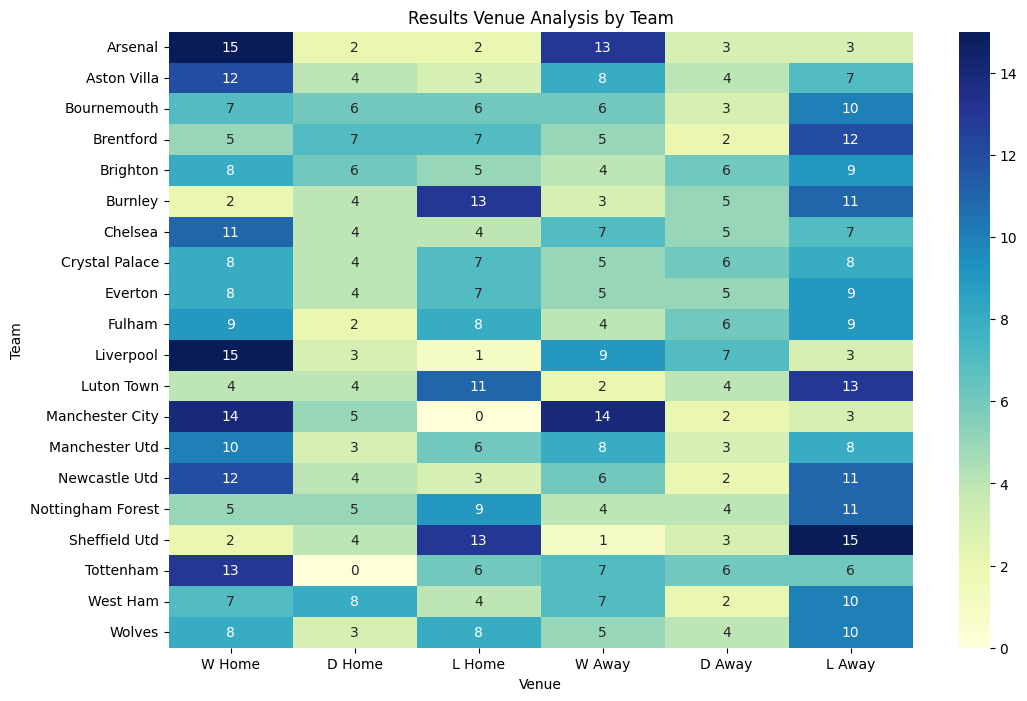

In [61]:
results_venue_teams = teamshomeaway[['Team', 'MP Home', 'W Home', 'D Home', 'L Home', 'MP Away', 'W Away', 'D Away', 'L Away']]

melted_results_venue_teams = pd.melt(results_venue_teams, id_vars=['Team'],
                        value_vars=['MP Home', 'W Home', 'D Home', 'L Home', 'MP Away', 'W Away', 'D Away', 'L Away'],
                        var_name='Results Venue', value_name='Results')

heatmap_data_results_venue = melted_results_venue_teams.pivot_table(index='Team', columns='Results Venue', values='Results')

columns_order = ['W Home', 'D Home', 'L Home', 'W Away', 'D Away', 'L Away']
heatmap_data_results_venue = heatmap_data_results_venue[columns_order]

heatmap_data_results_venue = heatmap_data_results_venue.astype(int)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_results_venue, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Results Venue Analysis by Team')
plt.xlabel('Venue')
plt.ylabel('Team')
plt.show()